In [1]:
import numpy as np
import cv2
import torch

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
train_dir = 'data/train/'
test_dir = 'data/test/'

In [3]:
# Hyper params
batch_size = 64
epochs = 10
learning_rate = 1e-3

In [4]:
# Load data into dataloaders (generator)
train_transfomers  = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transformers = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_data = datasets.ImageFolder(
    train_dir, transform=train_transfomers
)

test_data = datasets.ImageFolder(
    test_dir, transform=test_transformers
)

num_train = len(train_data)
train_indices = list(range(num_train))

num_test = len(test_data)
test_indicies = list(range(num_test))

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indicies)

train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Text(0.5, 1.0, 'Fashion MNIST class distribution')

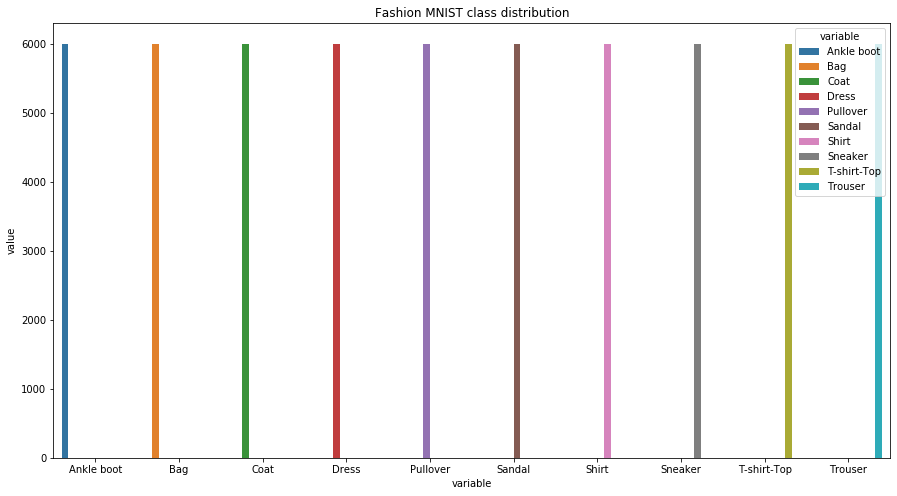

In [5]:
# Plot distribution of data
def get_class_distribution(dataset_obj):
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
    
    return count_dict

plt.figure(figsize=(15,8))
data = get_class_distribution(train_loader.dataset)
sns.barplot(
    data=pd.DataFrame.from_dict([data]).melt(),  x = "variable", y="value", hue="variable"
).set_title('Fashion MNIST class distribution')

In [6]:
# Transfer learning using resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 10),
    nn.LogSoftmax(dim=1)
)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
train_losses, test_losses = [], []
steps = 0
print_every = 10

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Training pass
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()

model_save_dir = 'model/'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

torch.save(model, model_save_dir + 'resnet_classifier_shuffle.pth')

Epoch 1/10.. Train loss: 2.155.. Test loss: 2.513.. Test accuracy: 0.105
Epoch 1/10.. Train loss: 1.776.. Test loss: 3.211.. Test accuracy: 0.143
Epoch 1/10.. Train loss: 1.624.. Test loss: 4.275.. Test accuracy: 0.148
Epoch 1/10.. Train loss: 1.441.. Test loss: 2.102.. Test accuracy: 0.365
Epoch 1/10.. Train loss: 1.406.. Test loss: 1.479.. Test accuracy: 0.519
Epoch 1/10.. Train loss: 1.393.. Test loss: 1.423.. Test accuracy: 0.510
Epoch 1/10.. Train loss: 1.426.. Test loss: 1.233.. Test accuracy: 0.589
Epoch 1/10.. Train loss: 1.263.. Test loss: 1.327.. Test accuracy: 0.574
Epoch 1/10.. Train loss: 1.295.. Test loss: 1.260.. Test accuracy: 0.576
Epoch 1/10.. Train loss: 1.322.. Test loss: 1.216.. Test accuracy: 0.602
Epoch 1/10.. Train loss: 1.238.. Test loss: 1.191.. Test accuracy: 0.595
Epoch 1/10.. Train loss: 1.172.. Test loss: 1.174.. Test accuracy: 0.610
Epoch 1/10.. Train loss: 1.282.. Test loss: 1.261.. Test accuracy: 0.571
Epoch 1/10.. Train loss: 1.184.. Test loss: 1.219..

Epoch 2/10.. Train loss: 0.920.. Test loss: 0.931.. Test accuracy: 0.664
Epoch 2/10.. Train loss: 0.890.. Test loss: 0.959.. Test accuracy: 0.661
Epoch 2/10.. Train loss: 0.894.. Test loss: 0.932.. Test accuracy: 0.671
Epoch 2/10.. Train loss: 0.930.. Test loss: 0.937.. Test accuracy: 0.667
Epoch 2/10.. Train loss: 0.900.. Test loss: 0.954.. Test accuracy: 0.656
Epoch 2/10.. Train loss: 0.956.. Test loss: 0.895.. Test accuracy: 0.674
Epoch 2/10.. Train loss: 0.960.. Test loss: 0.895.. Test accuracy: 0.678
Epoch 2/10.. Train loss: 0.885.. Test loss: 0.885.. Test accuracy: 0.681
Epoch 2/10.. Train loss: 0.940.. Test loss: 0.889.. Test accuracy: 0.686
Epoch 2/10.. Train loss: 0.992.. Test loss: 0.924.. Test accuracy: 0.665
Epoch 2/10.. Train loss: 0.952.. Test loss: 0.922.. Test accuracy: 0.670
Epoch 2/10.. Train loss: 0.898.. Test loss: 0.901.. Test accuracy: 0.675
Epoch 2/10.. Train loss: 0.957.. Test loss: 0.890.. Test accuracy: 0.679
Epoch 2/10.. Train loss: 0.989.. Test loss: 0.907..

Epoch 3/10.. Train loss: 0.859.. Test loss: 0.889.. Test accuracy: 0.679
Epoch 3/10.. Train loss: 0.887.. Test loss: 0.861.. Test accuracy: 0.681
Epoch 3/10.. Train loss: 0.836.. Test loss: 0.856.. Test accuracy: 0.691
Epoch 3/10.. Train loss: 0.855.. Test loss: 0.870.. Test accuracy: 0.683
Epoch 3/10.. Train loss: 0.827.. Test loss: 0.859.. Test accuracy: 0.691
Epoch 3/10.. Train loss: 0.922.. Test loss: 0.848.. Test accuracy: 0.693
Epoch 3/10.. Train loss: 0.922.. Test loss: 0.860.. Test accuracy: 0.686
Epoch 3/10.. Train loss: 0.948.. Test loss: 0.857.. Test accuracy: 0.687
Epoch 3/10.. Train loss: 0.865.. Test loss: 0.867.. Test accuracy: 0.682
Epoch 3/10.. Train loss: 0.802.. Test loss: 0.848.. Test accuracy: 0.692
Epoch 3/10.. Train loss: 0.851.. Test loss: 0.860.. Test accuracy: 0.686
Epoch 3/10.. Train loss: 0.912.. Test loss: 0.837.. Test accuracy: 0.695
Epoch 3/10.. Train loss: 0.903.. Test loss: 0.863.. Test accuracy: 0.686
Epoch 3/10.. Train loss: 0.845.. Test loss: 0.891..

Epoch 4/10.. Train loss: 0.830.. Test loss: 0.829.. Test accuracy: 0.699
Epoch 4/10.. Train loss: 0.861.. Test loss: 0.839.. Test accuracy: 0.692
Epoch 4/10.. Train loss: 0.815.. Test loss: 0.826.. Test accuracy: 0.700
Epoch 4/10.. Train loss: 0.860.. Test loss: 0.842.. Test accuracy: 0.689
Epoch 4/10.. Train loss: 0.807.. Test loss: 0.834.. Test accuracy: 0.695
Epoch 4/10.. Train loss: 0.798.. Test loss: 0.841.. Test accuracy: 0.694
Epoch 4/10.. Train loss: 0.878.. Test loss: 0.824.. Test accuracy: 0.696
Epoch 4/10.. Train loss: 0.874.. Test loss: 0.818.. Test accuracy: 0.699
Epoch 4/10.. Train loss: 0.836.. Test loss: 0.865.. Test accuracy: 0.683
Epoch 4/10.. Train loss: 0.835.. Test loss: 0.837.. Test accuracy: 0.697
Epoch 4/10.. Train loss: 0.835.. Test loss: 0.819.. Test accuracy: 0.695
Epoch 4/10.. Train loss: 0.857.. Test loss: 0.831.. Test accuracy: 0.691
Epoch 4/10.. Train loss: 0.928.. Test loss: 0.805.. Test accuracy: 0.703
Epoch 4/10.. Train loss: 0.736.. Test loss: 0.818..

Epoch 5/10.. Train loss: 0.843.. Test loss: 0.815.. Test accuracy: 0.698
Epoch 5/10.. Train loss: 0.818.. Test loss: 0.838.. Test accuracy: 0.691
Epoch 5/10.. Train loss: 0.802.. Test loss: 0.822.. Test accuracy: 0.704
Epoch 5/10.. Train loss: 0.880.. Test loss: 0.827.. Test accuracy: 0.693
Epoch 5/10.. Train loss: 0.853.. Test loss: 0.809.. Test accuracy: 0.703
Epoch 5/10.. Train loss: 0.839.. Test loss: 0.813.. Test accuracy: 0.702
Epoch 5/10.. Train loss: 0.839.. Test loss: 0.810.. Test accuracy: 0.702
Epoch 5/10.. Train loss: 0.847.. Test loss: 0.819.. Test accuracy: 0.698
Epoch 5/10.. Train loss: 0.837.. Test loss: 0.817.. Test accuracy: 0.703
Epoch 5/10.. Train loss: 0.960.. Test loss: 0.828.. Test accuracy: 0.692
Epoch 5/10.. Train loss: 0.776.. Test loss: 0.810.. Test accuracy: 0.704
Epoch 5/10.. Train loss: 0.802.. Test loss: 0.814.. Test accuracy: 0.708
Epoch 5/10.. Train loss: 0.896.. Test loss: 0.806.. Test accuracy: 0.706
Epoch 5/10.. Train loss: 0.846.. Test loss: 0.818..

Epoch 7/10.. Train loss: 0.791.. Test loss: 0.812.. Test accuracy: 0.705
Epoch 7/10.. Train loss: 0.852.. Test loss: 0.813.. Test accuracy: 0.706
Epoch 7/10.. Train loss: 0.791.. Test loss: 0.801.. Test accuracy: 0.707
Epoch 7/10.. Train loss: 0.831.. Test loss: 0.799.. Test accuracy: 0.708
Epoch 7/10.. Train loss: 0.770.. Test loss: 0.796.. Test accuracy: 0.711
Epoch 7/10.. Train loss: 0.889.. Test loss: 0.815.. Test accuracy: 0.700
Epoch 7/10.. Train loss: 0.787.. Test loss: 0.803.. Test accuracy: 0.704
Epoch 7/10.. Train loss: 0.758.. Test loss: 0.816.. Test accuracy: 0.704
Epoch 7/10.. Train loss: 0.795.. Test loss: 0.812.. Test accuracy: 0.704
Epoch 7/10.. Train loss: 0.814.. Test loss: 0.817.. Test accuracy: 0.701
Epoch 7/10.. Train loss: 0.775.. Test loss: 0.823.. Test accuracy: 0.699
Epoch 7/10.. Train loss: 0.704.. Test loss: 0.804.. Test accuracy: 0.707
Epoch 7/10.. Train loss: 0.847.. Test loss: 0.798.. Test accuracy: 0.708
Epoch 7/10.. Train loss: 0.774.. Test loss: 0.814..

Epoch 8/10.. Train loss: 0.797.. Test loss: 0.792.. Test accuracy: 0.712
Epoch 8/10.. Train loss: 0.766.. Test loss: 0.786.. Test accuracy: 0.714
Epoch 8/10.. Train loss: 0.789.. Test loss: 0.806.. Test accuracy: 0.705
Epoch 8/10.. Train loss: 0.747.. Test loss: 0.808.. Test accuracy: 0.708
Epoch 8/10.. Train loss: 0.818.. Test loss: 0.812.. Test accuracy: 0.706
Epoch 8/10.. Train loss: 0.726.. Test loss: 0.806.. Test accuracy: 0.708
Epoch 8/10.. Train loss: 0.753.. Test loss: 0.800.. Test accuracy: 0.710
Epoch 8/10.. Train loss: 0.766.. Test loss: 0.788.. Test accuracy: 0.711
Epoch 8/10.. Train loss: 0.760.. Test loss: 0.801.. Test accuracy: 0.712
Epoch 8/10.. Train loss: 0.802.. Test loss: 0.804.. Test accuracy: 0.706
Epoch 8/10.. Train loss: 0.817.. Test loss: 0.800.. Test accuracy: 0.707
Epoch 8/10.. Train loss: 0.749.. Test loss: 0.799.. Test accuracy: 0.707
Epoch 8/10.. Train loss: 0.751.. Test loss: 0.790.. Test accuracy: 0.712
Epoch 8/10.. Train loss: 0.725.. Test loss: 0.792..

Epoch 9/10.. Train loss: 0.861.. Test loss: 0.794.. Test accuracy: 0.712
Epoch 9/10.. Train loss: 0.776.. Test loss: 0.802.. Test accuracy: 0.707
Epoch 9/10.. Train loss: 0.910.. Test loss: 0.781.. Test accuracy: 0.711
Epoch 9/10.. Train loss: 0.857.. Test loss: 0.800.. Test accuracy: 0.705
Epoch 9/10.. Train loss: 0.783.. Test loss: 0.790.. Test accuracy: 0.716
Epoch 9/10.. Train loss: 0.805.. Test loss: 0.774.. Test accuracy: 0.718
Epoch 9/10.. Train loss: 0.817.. Test loss: 0.787.. Test accuracy: 0.713
Epoch 9/10.. Train loss: 0.810.. Test loss: 0.779.. Test accuracy: 0.717
Epoch 9/10.. Train loss: 0.789.. Test loss: 0.775.. Test accuracy: 0.715
Epoch 9/10.. Train loss: 0.840.. Test loss: 0.774.. Test accuracy: 0.715
Epoch 9/10.. Train loss: 0.758.. Test loss: 0.776.. Test accuracy: 0.718
Epoch 9/10.. Train loss: 0.781.. Test loss: 0.789.. Test accuracy: 0.712
Epoch 9/10.. Train loss: 0.836.. Test loss: 0.800.. Test accuracy: 0.704
Epoch 9/10.. Train loss: 0.867.. Test loss: 0.797..

Epoch 10/10.. Train loss: 0.815.. Test loss: 0.782.. Test accuracy: 0.709
Epoch 10/10.. Train loss: 0.812.. Test loss: 0.771.. Test accuracy: 0.714
Epoch 10/10.. Train loss: 0.782.. Test loss: 0.779.. Test accuracy: 0.713
Epoch 10/10.. Train loss: 0.832.. Test loss: 0.775.. Test accuracy: 0.717
Epoch 10/10.. Train loss: 0.808.. Test loss: 0.783.. Test accuracy: 0.720
Epoch 10/10.. Train loss: 0.810.. Test loss: 0.796.. Test accuracy: 0.713
Epoch 10/10.. Train loss: 0.763.. Test loss: 0.785.. Test accuracy: 0.710
Epoch 10/10.. Train loss: 0.770.. Test loss: 0.789.. Test accuracy: 0.712
Epoch 10/10.. Train loss: 0.760.. Test loss: 0.784.. Test accuracy: 0.711
Epoch 10/10.. Train loss: 0.698.. Test loss: 0.784.. Test accuracy: 0.714
Epoch 10/10.. Train loss: 0.814.. Test loss: 0.804.. Test accuracy: 0.714
Epoch 10/10.. Train loss: 0.797.. Test loss: 0.795.. Test accuracy: 0.710
Epoch 10/10.. Train loss: 0.829.. Test loss: 0.785.. Test accuracy: 0.712
Epoch 10/10.. Train loss: 0.747.. Test

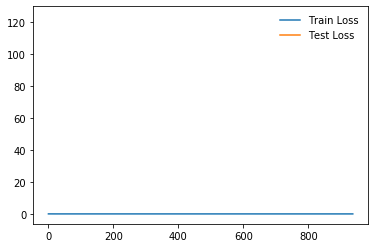

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend(frameon=False)
plt.show()